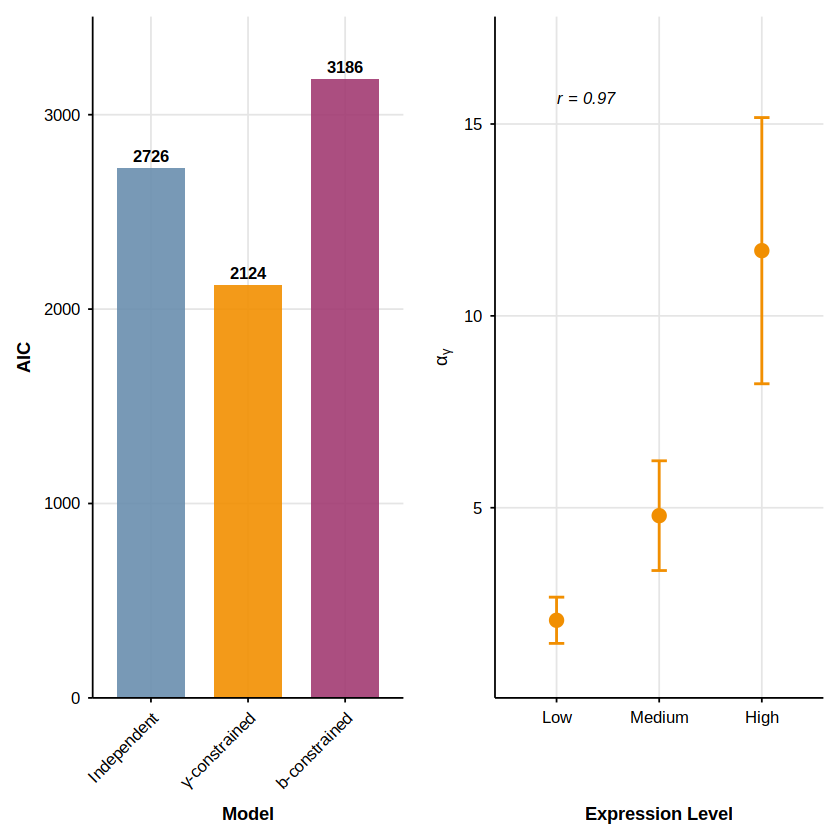

In [4]:
library(ggplot2)
library(patchwork)
library(gridExtra)
library(grid)

# ---------------------------
# Load fitted model data
# ---------------------------
fit_low <- readRDS("data_fit_model1_UB_36_low.rds")
fit_medium <- readRDS("data_fit_model1_UB_36_medium.rds")
fit_high <- readRDS("data_fit_model1_UB_36_high.rds")

# ---------------------------
# Extract parameter estimates and standard errors
# ---------------------------
params_df <- data.frame(
  Expression = factor(c("Low", "Medium", "High"), levels = c("Low", "Medium", "High")),
  Alpha = c(fit_low$estimate$alpha, fit_medium$estimate$alpha, fit_high$estimate$alpha),
  Beta  = c(fit_low$estimate$beta,  fit_medium$estimate$beta,  fit_high$estimate$beta),
  Alpha_SD = c(fit_low$standard_errors$alpha, fit_medium$standard_errors$alpha, fit_high$standard_errors$alpha),
  Beta_SD  = c(fit_low$standard_errors$beta,  fit_medium$standard_errors$beta,  fit_high$standard_errors$beta)
)

# ---------------------------
# Publication theme
# ---------------------------
publication_theme <- theme_minimal(base_size = 11) +
  theme(
    panel.background = element_rect(fill = "white", color = NA),
    plot.background = element_rect(fill = "white", color = NA),
    panel.grid.major = element_line(color = "grey90", linewidth = 0.5),
    panel.grid.minor = element_blank(),
    axis.line = element_line(color = "black", linewidth = 0.5),
    axis.ticks = element_line(color = "black", linewidth = 0.5),
    axis.text = element_text(color = "black", size = 10),
    axis.title = element_text(color = "black", size = 11, face = "bold"),
    plot.title = element_text(size = 12, face = "bold", hjust = 0.5),
    legend.position = "none",
    plot.margin = margin(10, 10, 10, 10)
  )

# ---------------------------
# AIC comparison bar chart (LEFT PLOT)
# ---------------------------
aic_data <- data.frame(
  Model = factor(c("Independent", "γ-constrained", "b-constrained"), 
                 levels = c("Independent", "γ-constrained", "b-constrained")),
  AIC = c(2726, 2124, 3186)
)

p_aic <- ggplot(aic_data, aes(x = Model, y = AIC, fill = Model)) +
  geom_col(width = 0.7, alpha = 0.9) +
  geom_text(aes(label = AIC), vjust = -0.5, size = 3.5, fontface = "bold") +
  scale_fill_manual(values = c("Independent" = "#6A8EAE", 
                               "γ-constrained" = "#F18F01", 
                               "b-constrained" = "#A23B72")) +
  labs(x = "Model", y = "AIC") +
  scale_y_continuous(expand = expansion(mult = c(0, 0.1))) +
  publication_theme +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))

# ---------------------------
# Beta plot with gamma symbol (RIGHT PLOT)
# ---------------------------
cor_beta <- cor.test(as.numeric(params_df$Expression), params_df$Beta)

p_beta <- ggplot(params_df, aes(x = Expression, y = Beta)) +
  geom_point(size = 3, color = "#F18F01", fill = "#F18F01", shape = 21, stroke = 1) +
  geom_errorbar(aes(ymin = Beta - Beta_SD, ymax = Beta + Beta_SD), 
                width = 0.15, color = "#F18F01", linewidth = 0.8) +
  # geom_smooth(
  #   aes(x = as.numeric(Expression), y = Beta),
  #   method = "lm", se = FALSE,
  #   color = "#A23B72", linetype = "solid", linewidth = 1.2
  # ) +
  annotate(
    "text", x = 1, y = max(params_df$Beta + params_df$Beta_SD, na.rm = TRUE) + 0.5,
    label = paste("r =", round(cor_beta$estimate, 3), 
                  ifelse(cor_beta$p.value > 0.1, "", 
                         paste("p =", round(cor_beta$p.value, 3)))),
    hjust = 0, size = 3.5, fontface = "italic"
  ) +
  labs(x = "Expression Level", y = expression(α[γ])) +
  scale_y_continuous(expand = expansion(mult = c(0.1, 0.15))) +
  publication_theme

# ---------------------------
# Combine plots with perfect vertical alignment
# ---------------------------
# Convert to grobs for precise alignment
aic_grob <- ggplotGrob(p_aic)
beta_grob <- ggplotGrob(p_beta)

# Ensure both plots have the same height for perfect alignment
max_height <- unit.pmax(aic_grob$heights, beta_grob$heights)
aic_grob$heights <- max_height
beta_grob$heights <- max_height

# Combine without title
final_plot <- grid.arrange(
  aic_grob, 
  beta_grob,
  ncol = 2,
  widths = c(1, 1)  # Equal widths
)

# ---------------------------
# Save combined plot only
# ---------------------------

ggsave("AICs_binned_parameter.pdf", plot = final_plot, 
       width = 10, height = 5, bg = "white", device = cairo_pdf)
